In [11]:
!pip install xgboost
!pip install deslib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
import lib_analise 
lib_analise.print_informacao_analise()


Nome do dataset:  svm
X_train.shape (32259, 48)
X_test.shape (24194, 48)
X_val.shape (24195, 48)
X_train_scaled.shape (32259, 48)
X_test_scaled.shape (24194, 48)
X_val_scaled.shape (24195, 48)
classes_mapping {'interf': np.int64(0), 'normal': np.int64(1)}
features_ganho_informacao ['mean_container_mem_pgpgin', 'mean_container_net_tx_packets', 'mean_os_mem_nr_mapped', 'mean_container_net_rx_packets', 'mean_os_mem_pgpgout', 'mean_os_disk_write_sectors', 'mean_os_disk_write_io', 'mean_container_cpu_user', 'mean_container_cpu_system', 'mean_container_mem_active_file', 'mean_os_mem_nr_active_file', 'mean_os_disk_time_in_queue', 'mean_container_mem_rss', 'mean_container_mem_inactive_anon', 'mean_container_mem_mapped_file', 'mean_os_disk_write_ticks', 'mean_os_mem_pgmajfault', 'mean_os_mem_pgpgin', 'mean_os_disk_io_ticks', 'mean_os_disk_read_ticks', 'mean_os_mem_nr_inactive_anon', 'mean_os_disk_write_merge', 'mean_container_disk_8:0_async', 'mean_container_mem_active_anon', 'mean_process_mem_

In [13]:



import lib_analise
import matplotlib.pyplot as plt
import matplotlib as pl
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from deslib.util.datasets import make_P2
from sklearn.model_selection import GridSearchCV
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits, load_breast_cancer, load_iris
import itertools
import pandas as pd
import seaborn as sns
import urllib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [14]:
#variaveis globais
import lib_analise 
rng = np.random.RandomState(123)
info_modelo = lib_analise.get_info_modelo()  # para garantir que a função está carregada da
nome_dataset = info_modelo['nome_dataset']
datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=False)
lib_analise.print_informacao_analise()
arq_dataset_csv = info_modelo['parametros']['arq_dataset_csv']
arq_dataset_pkl = info_modelo['parametros']['arq_dataset_pkl']
titles_test = None

Nome do dataset:  svm
X_train.shape (32259, 48)
X_test.shape (24194, 48)
X_val.shape (24195, 48)
X_train_scaled.shape (32259, 48)
X_test_scaled.shape (24194, 48)
X_val_scaled.shape (24195, 48)
classes_mapping {'interf': np.int64(0), 'normal': np.int64(1)}
features_ganho_informacao ['mean_container_mem_pgpgin', 'mean_container_net_tx_packets', 'mean_os_mem_nr_mapped', 'mean_container_net_rx_packets', 'mean_os_mem_pgpgout', 'mean_os_disk_write_sectors', 'mean_os_disk_write_io', 'mean_container_cpu_user', 'mean_container_cpu_system', 'mean_container_mem_active_file', 'mean_os_mem_nr_active_file', 'mean_os_disk_time_in_queue', 'mean_container_mem_rss', 'mean_container_mem_inactive_anon', 'mean_container_mem_mapped_file', 'mean_os_disk_write_ticks', 'mean_os_mem_pgmajfault', 'mean_os_mem_pgpgin', 'mean_os_disk_io_ticks', 'mean_os_disk_read_ticks', 'mean_os_mem_nr_inactive_anon', 'mean_os_disk_write_merge', 'mean_container_disk_8:0_async', 'mean_container_mem_active_anon', 'mean_process_mem_

In [15]:

import lib_analise
from sklearn.preprocessing import  PowerTransformer
# Normalização dos dados usando Yeo-Johnson
def normalization_dataset(datasets):
    print(f"\n⚖️ Aplicando transformação Yeo-Johnson...")
    datasets['yeo_johnson_transformer'] = PowerTransformer(method='yeo-johnson', standardize=True)
    # O fit é feito apenas no conjunto de treino para evitar data leakage
    datasets['X_train_scaled'] = datasets['yeo_johnson_transformer'].fit_transform(datasets['X_train'])
    datasets['X_test_scaled'] = datasets['yeo_johnson_transformer'].transform(datasets['X_test'])
    datasets['X_val_scaled'] = datasets['yeo_johnson_transformer'].transform(datasets['X_val'])
    lib_analise.save_informacao_analise(datasets = datasets)
    print(f"   ✅ Transformação Yeo-Johnson aplicada com StandardScaler integrado")
    print(f"   • Média treino antes: {datasets['X_train'].mean().mean():.3f} | depois: {datasets['X_train_scaled'].mean():.3f}")
    print(f"   • Std treino antes: {datasets['X_train'].std().mean():.3f} | depois: {datasets['X_train_scaled'].std().mean():.3f}")
    print(f"   • Média teste antes: {datasets['X_test'].mean().mean():.3f} | depois: {datasets['X_test_scaled'].mean():.3f}")
    print(f"   • Std teste antes: {datasets['X_test'].std().mean():.3f} | depois: {datasets['X_test_scaled'].std().mean():.3f}")
    print(f"   • Média validação antes: {datasets['X_val'].mean().mean():.3f} | depois: {datasets['X_val_scaled'].mean():.3f}")
    print(f"   • Std validação antes: {datasets['X_val'].std().mean():.3f} | depois: {datasets['X_val_scaled'].std().mean():.3f}")
    print(f"   • Transformação aplicada: Yeo-Johnson + Padronização")
    return datasets

datasets = normalization_dataset(datasets)



⚖️ Aplicando transformação Yeo-Johnson...
✅ Dataset salvo com sucesso em ../dataset/svm.pkl
   ✅ Transformação Yeo-Johnson aplicada com StandardScaler integrado
   • Média treino antes: 94174.967 | depois: 0.000
   • Std treino antes: 2795694.750 | depois: 0.829
   • Média teste antes: 84236.461 | depois: -0.002
   • Std teste antes: 2843191.188 | depois: 0.840
   • Média validação antes: 76354.600 | depois: -0.001
   • Std validação antes: 2791007.310 | depois: 0.850
   • Transformação aplicada: Yeo-Johnson + Padronização
✅ Dataset salvo com sucesso em ../dataset/svm.pkl
   ✅ Transformação Yeo-Johnson aplicada com StandardScaler integrado
   • Média treino antes: 94174.967 | depois: 0.000
   • Std treino antes: 2795694.750 | depois: 0.829
   • Média teste antes: 84236.461 | depois: -0.002
   • Std teste antes: 2843191.188 | depois: 0.840
   • Média validação antes: 76354.600 | depois: -0.001
   • Std validação antes: 2791007.310 | depois: 0.850
   • Transformação aplicada: Yeo-Johnso

In [16]:
# Define single classifiers (monolithic Classifiers)

"""
dt =  DecisionTreeClassifier(criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=3)
knnw = KNeighborsClassifier(n_neighbors=3, weights='distance')
mlp = MLPClassifier(solver='lbfgs', early_stopping=True, hidden_layer_sizes=(32), activation='logistic', batch_size=100, max_iter=10000, learning_rate_init=0.001, momentum=0.8, random_state=46)
nb = GaussianNB(var_smoothing=1e-09)

# parameters for SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm = SVC(gamma='scale', probability=True, random_state=42)
svm = GridSearchCV(svm, parameters, scoring = 'accuracy', cv=10)

# Define ensembles (homogeneous and heterogeneous)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
cb = VotingClassifier(estimators=[('DecisionTree', dt), ('NaiveBayes', nb), ('knn', knn)], voting='soft')
bg = BaggingClassifier(estimator=knn, n_estimators=100, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

#titles = ['DecisionTree', 'KNN', 'KNN_W', 'NaiveBayes', 'MLP', 'SVM', 'RF', 'DT+NB+KNN', 'Bag', 'Ada', 'XGBoost']
#methods = [dt, knn, knnw, nb, mlp, svm, rf, cb, bg, ada, xgboost]

titles = ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost','ADA', 'MLP']
methods = [dt, rf, knn, nb, xgboost,ada, mlp]

"""



'\ndt =  DecisionTreeClassifier(criterion=\'entropy\')\nknn = KNeighborsClassifier(n_neighbors=3)\nknnw = KNeighborsClassifier(n_neighbors=3, weights=\'distance\')\nmlp = MLPClassifier(solver=\'lbfgs\', early_stopping=True, hidden_layer_sizes=(32), activation=\'logistic\', batch_size=100, max_iter=10000, learning_rate_init=0.001, momentum=0.8, random_state=46)\nnb = GaussianNB(var_smoothing=1e-09)\n\n# parameters for SVM\nparameters = [\n  {\'C\': [0.1, 0.5, 1, 10, 100, 500, 1000], \'kernel\': [\'poly\']},\n  {\'C\': [0.1, 0.5, 1, 10, 100, 500, 1000], \'gamma\': [0.1, 0.001, 0.0001, 0.00001], \'kernel\': [\'rbf\']},\n]\nsvm = SVC(gamma=\'scale\', probability=True, random_state=42)\nsvm = GridSearchCV(svm, parameters, scoring = \'accuracy\', cv=10)\n\n# Define ensembles (homogeneous and heterogeneous)\nrf = RandomForestClassifier(n_estimators=100, random_state=0)\ncb = VotingClassifier(estimators=[(\'DecisionTree\', dt), (\'NaiveBayes\', nb), (\'knn\', knn)], voting=\'soft\')\nbg = Bagg

In [17]:
def create_classifiers(titles=None):
    """
    Cria e configura classificadores de machine learning
    
    Parâmetros:
    - titles: lista de nomes dos classificadores desejados (opcional)
              Se None, retorna todos os classificadores disponíveis
    
    Retorna:
    - tuple (titles, methods): listas com nomes e objetos dos classificadores
    """
    
    # Definir todos os classificadores disponíveis
    available_classifiers = {
        'DecisionTree': DecisionTreeClassifier(criterion='entropy'),
        'KNN': KNeighborsClassifier(n_neighbors=3),
        'KNN_W': KNeighborsClassifier(n_neighbors=3, weights='distance'),
        'NaiveBayes': GaussianNB(var_smoothing=1e-09),
        'MLP': MLPClassifier(solver='lbfgs', early_stopping=True, hidden_layer_sizes=(32), 
                           activation='logistic', batch_size=100, max_iter=10000, 
                           learning_rate_init=0.001, momentum=0.8, random_state=46),
        'RF': RandomForestClassifier(n_estimators=100, random_state=0),
        'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=42),
        'ADA': AdaBoostClassifier(n_estimators=100, random_state=0),
        'Bag': BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3), n_estimators=100, random_state=0)
    }
    
    # Configurar SVM com GridSearch
    svm_parameters = [
        {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
        {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
    ]
    svm_base = SVC(gamma='scale', probability=True, random_state=42)
    available_classifiers['SVM'] = GridSearchCV(svm_base, svm_parameters, scoring='accuracy', cv=10)
    
    # Configurar ensemble voting
    dt_for_voting = DecisionTreeClassifier(criterion='entropy')
    nb_for_voting = GaussianNB(var_smoothing=1e-09)
    knn_for_voting = KNeighborsClassifier(n_neighbors=3)
    
    available_classifiers['DT+NB+KNN'] = VotingClassifier(
        estimators=[('DecisionTree', dt_for_voting), ('NaiveBayes', nb_for_voting), ('knn', knn_for_voting)], 
        voting='soft'
    )
    
    # Se titles não foi especificado, usar configuração padrão
    if titles is None:
        titles = ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']
    
    # Validar se todos os classificadores solicitados existem
    methods = []
    valid_titles = []
    
    print(f"🔧 Configurando classificadores solicitados...")
    
    for title in titles:
        if title in available_classifiers:
            methods.append(available_classifiers[title])
            valid_titles.append(title)
            print(f"   ✅ {title}: Configurado")
        else:
            print(f"   ❌ {title}: Classificador não encontrado")
            print(f"      Disponíveis: {list(available_classifiers.keys())}")
    
    print(f"\n📊 Resumo:")
    print(f"   • Classificadores solicitados: {len(titles)}")
    print(f"   • Classificadores configurados: {len(valid_titles)}")
    print(f"   • Lista final: {valid_titles}")
    
    return methods, valid_titles

def teste_create_classifiers(titles=None):
    """
    Testa a função create_classifiers e exibe os resultados
    """
    # Exemplo de uso da função
    print("🚀 DEMONSTRAÇÃO DA FUNÇÃO create_classifiers()")
    print("=" * 60)

    # Usar configuração padrão
    titles, methods = create_classifiers()

    # Ou especificar classificadores específicos
    # titles_custom = ['DecisionTree', 'RF', 'SVM', 'XGBoost'] 
    # titles, methods = create_classifiers(titles_custom)

    print(f"\n✅ Função criada com sucesso!")
    print(f"📋 Classificadores configurados: {len(methods)}")
    print(f"🎯 Títulos: {titles}")

titles, methods = create_classifiers()

🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado
   ✅ RF: Configurado
   ✅ KNN: Configurado
   ✅ NaiveBayes: Configurado
   ✅ XGBoost: Configurado
   ✅ ADA: Configurado

📊 Resumo:
   • Classificadores solicitados: 6
   • Classificadores configurados: 6
   • Lista final: ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']


In [18]:
# Fit the classifiers


methods, titles = create_classifiers()
print(titles)
scores = []
for method, name in zip(methods, titles):
    method.fit(datasets['X_train_scaled'], datasets['y_train'])
    scores.append(method.score(datasets['X_test_scaled'], datasets['y_test']))
    print("Classification accuracy {} = {}"
          .format(name, method.score(datasets['X_test_scaled'], datasets['y_test'])))


🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado
   ✅ RF: Configurado
   ✅ KNN: Configurado
   ✅ NaiveBayes: Configurado
   ✅ XGBoost: Configurado
   ✅ ADA: Configurado

📊 Resumo:
   • Classificadores solicitados: 6
   • Classificadores configurados: 6
   • Lista final: ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']
['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']
Classification accuracy DecisionTree = 0.8333884434157229
Classification accuracy DecisionTree = 0.8333884434157229
Classification accuracy RF = 0.8959659419690832
Classification accuracy RF = 0.8959659419690832
Classification accuracy KNN = 0.8568653385136811
Classification accuracy NaiveBayes = 0.5073985285608001
Classification accuracy KNN = 0.8568653385136811
Classification accuracy NaiveBayes = 0.5073985285608001
Classification accuracy XGBoost = 0.9271720261221791
Classification accuracy XGBoost = 0.9271720261221791
Classification accuracy ADA = 0.7239398197900306


In [19]:
def train_classifiers(titles=None, X_train=None, y_train=None, verbose=True):
    """
    Treina classificadores de machine learning
    
    Parâmetros:
    - titles: lista de nomes dos classificadores desejados
    - X_train: dados de treino (features)
    - y_train: rótulos de treino (target)
    - verbose: se True, exibe progresso detalhado
    
    Retorna:
    - dict: dicionário com modelos treinados e status
    """
    
    methods, titles = create_classifiers(titles)
    
    if verbose:
        print("🔧 TREINANDO CLASSIFICADORES")
        print("=" * 50)
        print(f"📊 Configuração:")
        print(f"   • Número de classificadores: {len(methods)}")
        print(f"   • Shape treino: {X_train.shape}")
        print(f"   • Classes únicas: {len(np.unique(y_train))}")
    
    # Dicionário para armazenar os modelos treinados
    trained_models = {}

    # Treinar cada classificador
    for i, (method, name) in enumerate(zip(methods, titles)):
        print("Method:", method)
        if verbose:
            print(f"\n🔍 [{i+1}/{len(methods)}] Treinando: {name}")
        
        try:
            # Treinar o modelo
            if verbose:
                print(f"   🎯 Treinando modelo...")
            
            method.fit(X_train, y_train)
            
            trained_models[name] = {
                'model': method,
                'status': 'success'
            }
            
            if verbose:
                print(f"   ✅ {name}: Treinamento concluído com sucesso")
                
        except Exception as e:
            if verbose:
                print(f"   ❌ Erro ao treinar {name}: {str(e)}")
            
            trained_models[name] = {
                'model': method,
                'status': 'error',
                'error': str(e)
            }
    
    if verbose:
        successful_models = {k: v for k, v in trained_models.items() if v['status'] == 'success'}
        error_models = {k: v for k, v in trained_models.items() if v['status'] == 'error'}
        
        print(f"\n📈 RESUMO DO TREINAMENTO:")
        print("=" * 40)
        print(f"✅ Modelos treinados com sucesso: {len(successful_models)}")
        if error_models:
            print(f"❌ Modelos com erro: {len(error_models)}")
            for name, data in error_models.items():
                print(f"   • {name}: {data['error']}")
    
    return trained_models


def test_train_classifiers(titles):    
   
    print("\n1️⃣ ETAPA DE TREINAMENTO:")
    trained_models = train_classifiers(
        titles=titles,
        X_train=datasets['X_train_scaled'],
        y_train=datasets['y_train'],
        verbose=True
    )
    print(trained_models)
    print("\n" + "="*60)
    return trained_models

trained_models = test_train_classifiers(titles_test)
print(trained_models)


1️⃣ ETAPA DE TREINAMENTO:
🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado
   ✅ RF: Configurado
   ✅ KNN: Configurado
   ✅ NaiveBayes: Configurado
   ✅ XGBoost: Configurado
   ✅ ADA: Configurado

📊 Resumo:
   • Classificadores solicitados: 6
   • Classificadores configurados: 6
   • Lista final: ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']
🔧 TREINANDO CLASSIFICADORES
📊 Configuração:
   • Número de classificadores: 6
   • Shape treino: (32259, 48)
   • Classes únicas: 2
Method: DecisionTreeClassifier(criterion='entropy')

🔍 [1/6] Treinando: DecisionTree
   🎯 Treinando modelo...
   ✅ DecisionTree: Treinamento concluído com sucesso
Method: RandomForestClassifier(random_state=0)

🔍 [2/6] Treinando: RF
   🎯 Treinando modelo...
   ✅ DecisionTree: Treinamento concluído com sucesso
Method: RandomForestClassifier(random_state=0)

🔍 [2/6] Treinando: RF
   🎯 Treinando modelo...
   ✅ RF: Treinamento concluído com sucesso
Method: KNeighborsClassifier(n_

In [20]:

def evaluate_classifiers(trained_models, titles, X_test_scaled, y_test, verbose=True):
    """
    Avalia classificadores treinados de machine learning
    
    Parâmetros:
    - trained_models: dicionário com modelos treinados (resultado de train_classifiers)
    - titles: lista de nomes dos classificadores
    - X_test: dados de teste (features) 
    - y_test: rótulos de teste (target)
    - verbose: se True, exibe progresso detalhado
    
    Retorna:
    - tuple: (results dict, scores list) com métricas de acurácia por classificador
    """
    
    if verbose:
        print("📊 AVALIANDO CLASSIFICADORES")
        print("=" * 50)
        print(f"🎯 Configuração:")
        print(f"   • Número de modelos: {len(trained_models)}")
        print(f"   • Shape teste: {X_test_scaled.shape}")
        print(f"   • Classes únicas: {len(np.unique(y_test))}")
    
    # Dicionário para armazenar os resultados
    results = {}
    scores = []
    
    # Avaliar cada classificador
    for i, name in enumerate(titles):
        if name in trained_models:
            model_info = trained_models[name]
            
            if verbose:
                print(f"\n📊 [{i+1}/{len(titles)}] Avaliando: {name}")
            
            if model_info['status'] == 'success':
                try:
                    # Calcular acurácia no conjunto de teste
                    model = model_info['model']
                    accuracy = model.score(X_test_scaled, y_test)
                    scores.append(accuracy)
                    results[name] = {
                        'accuracy': accuracy,
                        'model': model,
                        'status': 'success'
                    }
                    
                    if verbose:
                        print(f"   ✅ Classification accuracy {name} = {accuracy:.4f}")
                        
                except Exception as e:
                    if verbose:
                        print(f"   ❌ Erro ao avaliar {name}: {str(e)}")
                    
                    scores.append(None)
                    results[name] = {
                        'accuracy': None,
                        'model': model_info['model'],
                        'status': 'error',
                        'error': str(e)
                    }
            else:
                # Modelo não foi treinado com sucesso
                if verbose:
                    print(f"   ⚠️ {name}: Modelo não foi treinado (pulando avaliação)")
                
                scores.append(None)
                results[name] = {
                    'accuracy': None,
                    'model': model_info['model'],
                    'status': 'not_trained',
                    'error': model_info.get('error', 'Modelo não foi treinado com sucesso')
                }
    
    if verbose:
        print(f"\n📈 RESUMO DOS RESULTADOS:")
        print("=" * 50)
        
        # Filtrar apenas sucessos
        successful_results = {k: v for k, v in results.items() if v['status'] == 'success'}
        
        if successful_results:
            # Ordenar por acurácia
            sorted_results = sorted(successful_results.items(), 
                                  key=lambda x: x[1]['accuracy'], 
                                  reverse=True)
            
            print(f"✅ Modelos avaliados com sucesso: {len(successful_results)}")
            print(f"📊 Ranking por acurácia:")
            
            for rank, (name, data) in enumerate(sorted_results, 1):
                medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank:2d}."
                print(f"   {medal} {name:15s}: {data['accuracy']:7.4f}")
            
            # Estatísticas resumidas
            accuracies = [data['accuracy'] for data in successful_results.values()]
            print(f"\n📊 Estatísticas:")
            print(f"   • Melhor acurácia: {max(accuracies):.4f}")
            print(f"   • Pior acurácia: {min(accuracies):.4f}")
            print(f"   • Acurácia média: {np.mean(accuracies):.4f}")
            print(f"   • Desvio padrão: {np.std(accuracies):.4f}")
        
        # Relatório de erros
        error_results = {k: v for k, v in results.items() if v['status'] in ['error', 'not_trained']}
        if error_results:
            print(f"\n❌ Modelos com problemas: {len(error_results)}")
            for name, data in error_results.items():
                print(f"   • {name}: {data['error']}")
    
    return results, scores

def test_evaluate_classifiers(titles=None):
    print("\n2️⃣ ETAPA DE AVALIAÇÃO:")
    
    trained_models = train_classifiers(
        titles=titles,
        X_train=datasets['X_train_scaled'],
        y_train=datasets['y_train'],
        verbose=False
    )
    results, scores = evaluate_classifiers(
        trained_models=trained_models,
        titles=['DecisionTree', 'RF', 'KNN'],
        X_test_scaled=datasets['X_test_scaled'],
        y_test=datasets['y_test'],
        verbose=True
    )
    print(results)
    print("\n" + "="*60)

results, scores = evaluate_classifiers(
        trained_models=trained_models,
        titles=titles_test,
        X_test_scaled=datasets['X_test_scaled'],
        y_test=datasets['y_test'],
        verbose=True
    )

📊 AVALIANDO CLASSIFICADORES
🎯 Configuração:
   • Número de modelos: 6
   • Shape teste: (24194, 48)
   • Classes únicas: 2


TypeError: 'NoneType' object is not iterable

In [ ]:
def generate_model_metrics_dataset(methods, titles, X_test, y_test, dataset_name, 
                                   save_to_csv=True, save_dir='../dataset', 
                                   display_results=True, verbose=True):
    """
    Gera dataset completo com métricas de avaliação para múltiplos modelos de ML
    
    Parâmetros:
    - methods: lista de objetos classificadores treinados
    - titles: lista de nomes dos classificadores
    - X_test: dados de teste (features)
    - y_test: rótulos de teste (target)
    - dataset_name: nome do dataset para identificação
    - save_to_csv: se True, salva o dataset em arquivo CSV
    - save_dir: diretório para salvar o arquivo CSV
    - display_results: se True, exibe tabelas e estatísticas detalhadas
    - verbose: se True, exibe progresso detalhado
    
    Retorna:
    - pandas.DataFrame: DataFrame com métricas de todos os modelos
    """
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    import pandas as pd
    import os
    from datetime import datetime
    import numpy as np
    
    if verbose:
        print("📊 GERANDO DATASET COM MÉTRICAS DE AVALIAÇÃO DOS MODELOS")
        print("=" * 70)
        print(f"🎯 Configuração:")
        print(f"   • Número de modelos: {len(methods)}")
        print(f"   • Dataset: {dataset_name}")
        print(f"   • Shape dados teste: {X_test.shape}")
        print(f"   • Classes únicas: {len(np.unique(y_test))}")
        print(f"   • Salvar CSV: {'Sim' if save_to_csv else 'Não'}")
    
    # Lista para armazenar as métricas
    metrics_data = []
    
    # Iterar por todos os modelos treinados
    for i, (clf, title) in enumerate(zip(methods, titles)):
        if verbose:
            print(f"\n🔍 [{i+1}/{len(methods)}] Avaliando modelo: {title}")
        
        try:
            # Fazer predições no conjunto de teste
            y_pred = clf.predict(X_test)
            
            # Calcular métricas principais
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            # Adicionar dados à lista
            metrics_data.append({
                'modelo': title,
                'acuracia': accuracy,
                'precisao': precision,
                'recall': recall,
                'f1_score': f1,
                'dataset': dataset_name,
                'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'num_amostras_teste': len(y_test),
                'num_classes': len(np.unique(y_test)),
                'status': 'success'
            })
            
            if verbose:
                print(f"   ✅ {title}: Acurácia={accuracy:.4f}, Precisão={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
                
        except Exception as e:
            if verbose:
                print(f"   ❌ Erro ao avaliar {title}: {e}")
            
            # Adicionar dados com erro
            metrics_data.append({
                'modelo': title,
                'acuracia': None,
                'precisao': None,
                'recall': None,
                'f1_score': None,
                'dataset': dataset_name,
                'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'num_amostras_teste': len(y_test),
                'num_classes': len(np.unique(y_test)),
                'status': 'error',
                'erro': str(e)
            })

    # Criar DataFrame com as métricas
    metrics_df = pd.DataFrame(metrics_data)
    
    if display_results and verbose:
        # Exibir o dataset
        print(f"\n📋 DATASET DE MÉTRICAS GERADO:")
        print("=" * 80)
        display_columns = ['modelo', 'acuracia', 'precisao', 'recall', 'f1_score', 'status']
        print(metrics_df[display_columns].to_string(index=False, float_format='%.4f'))
        
        # Estatísticas resumidas
        print(f"\n📈 ESTATÍSTICAS RESUMIDAS:")
        print("=" * 50)
        
        # Filtrar apenas modelos com sucesso
        valid_metrics = metrics_df[metrics_df['acuracia'].notna()]
        
        if len(valid_metrics) > 0:
            print(f"✅ Modelos avaliados com sucesso: {len(valid_metrics)}")
            print(f"❌ Modelos com erro: {len(metrics_df) - len(valid_metrics)}")
            
            # Melhores resultados por métrica
            print(f"\n🏆 MELHORES RESULTADOS:")
            print(f"   • Melhor acurácia: {valid_metrics['acuracia'].max():.4f} ({valid_metrics.loc[valid_metrics['acuracia'].idxmax(), 'modelo']})")
            print(f"   • Melhor precisão: {valid_metrics['precisao'].max():.4f} ({valid_metrics.loc[valid_metrics['precisao'].idxmax(), 'modelo']})")
            print(f"   • Melhor recall: {valid_metrics['recall'].max():.4f} ({valid_metrics.loc[valid_metrics['recall'].idxmax(), 'modelo']})")
            print(f"   • Melhor F1-Score: {valid_metrics['f1_score'].max():.4f} ({valid_metrics.loc[valid_metrics['f1_score'].idxmax(), 'modelo']})")
            
            # Médias das métricas
            print(f"\n📊 MÉDIAS DAS MÉTRICAS:")
            print(f"   • Acurácia média: {valid_metrics['acuracia'].mean():.4f} (±{valid_metrics['acuracia'].std():.4f})")
            print(f"   • Precisão média: {valid_metrics['precisao'].mean():.4f} (±{valid_metrics['precisao'].std():.4f})")
            print(f"   • Recall médio: {valid_metrics['recall'].mean():.4f} (±{valid_metrics['recall'].std():.4f})")
            print(f"   • F1-Score médio: {valid_metrics['f1_score'].mean():.4f} (±{valid_metrics['f1_score'].std():.4f})")
        else:
            print("❌ Nenhum modelo foi avaliado com sucesso!")
    
    # Salvar o dataset em arquivo CSV
    if save_to_csv:
        if verbose:
            print(f"\n💾 SALVANDO DATASET:")
            print("-" * 30)
        
        try:
            # Criar diretório se não existir
            os.makedirs(save_dir, exist_ok=True)
            
            # Gerar nome do arquivo com timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            metrics_filename = f'metricas_modelos_{dataset_name}_{timestamp}.csv'
            metrics_filepath = os.path.join(save_dir, metrics_filename)
            
            # Salvar arquivo
            metrics_df.to_csv(metrics_filepath, index=False, encoding='utf-8')
            
            if verbose:
                print(f"   ✅ Dataset salvo em: {metrics_filepath}")
                
                # Verificar o tamanho do arquivo
                file_size = os.path.getsize(metrics_filepath)
                print(f"   📁 Tamanho do arquivo: {file_size} bytes ({file_size/1024:.2f} KB)")
                
        except Exception as e:
            if verbose:
                print(f"   ❌ Erro ao salvar dataset: {e}")
    
    if display_results and verbose:
        # Ranking dos modelos por acurácia
        print(f"\n🏆 RANKING DOS MODELOS (por acurácia):")
        print("=" * 70)
        
        valid_models = metrics_df[metrics_df['acuracia'].notna()].copy()
        if len(valid_models) > 0:
            valid_models_sorted = valid_models.sort_values('acuracia', ascending=False).reset_index(drop=True)
            
            for i, row in valid_models_sorted.iterrows():
                medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1:2d}."
                print(f"{medal} {row['modelo']:15s}: {row['acuracia']:6.4f} " +
                      f"(Precisão: {row['precisao']:6.4f}, Recall: {row['recall']:6.4f}, F1: {row['f1_score']:6.4f})")
        
        # Listar erros se houver
        error_models = metrics_df[metrics_df['status'] == 'error']
        if len(error_models) > 0:
            print(f"\n❌ MODELOS COM ERRO:")
            print("-" * 40)
            for _, row in error_models.iterrows():
                erro_msg = row.get('erro', 'Erro não especificado')
                print(f"   • {row['modelo']}: {erro_msg}")
        
        print(f"\n🎉 Análise completa! Dataset gerado com {len(metrics_df)} modelos.")
        print(f"   • Sucessos: {len(valid_models)} modelos")
        print(f"   • Erros: {len(error_models)} modelos")
        print(f"💡 O DataFrame foi retornado para análises adicionais.")
    
    return metrics_df

# Exemplo de uso da função
print("🚀 DEMONSTRAÇÃO DA FUNÇÃO generate_model_metrics_dataset()")
print("=" * 75)


# Usar a função com os classificadores treinados
def test_generate_model_metrics_dataset(titles=None):
    metrics_df = generate_model_metrics_dataset(
    methods=methods,
    titles=titles,
    X_test=datasets['X_test_scaled'],
    y_test=datasets['y_test'],
    dataset_name=nome_dataset,
    save_to_csv=True,
    save_dir='../dataset',
    display_results=True,
    verbose=True
    )
    print(f"\n✅ Função executada com sucesso!")
    print(f"📊 DataFrame 'metrics_df' disponível com {len(metrics_df)} registros")
    print(f"🎯 Colunas disponíveis: {list(metrics_df.columns)}")

    # Exemplos de uso alternativo da função:
    print(f"\n💡 EXEMPLOS DE USO ALTERNATIVO:")
    print("-" * 50)
    print("# Uso mínimo (sem salvar, sem display detalhado):")
    print("# df = generate_model_metrics_dataset(methods, titles, X_test, y_test, 'meu_dataset', save_to_csv=False, display_results=False)")
    print()
    print("# Uso personalizado (salvar em diretório específico):")
    print("# df = generate_model_metrics_dataset(methods, titles, X_test, y_test, 'dataset_teste', save_dir='./resultados')")
    print()
    print("# Uso silencioso (apenas retornar DataFrame):")
    print("# df = generate_model_metrics_dataset(methods, titles, X_test, y_test, 'dataset_silent', verbose=False)")

metrics_df = generate_model_metrics_dataset(
    methods=methods,
    titles=titles,
    X_test=datasets['X_test_scaled'],
    y_test=datasets['y_test'],
    dataset_name=nome_dataset,
    save_to_csv=True,
    save_dir='../dataset',
    display_results=True,
    verbose=False
    )

metrics_df

🚀 DEMONSTRAÇÃO DA FUNÇÃO generate_model_metrics_dataset()


,modelo,acuracia,precisao,recall,f1_score,dataset,data_avaliacao,num_amostras_teste,num_classes,status
0,DecisionTree,0.834422,0.834558,0.834422,0.834483,svm,2025-10-19 09:01:04,24194,2,success
1,RF,0.895966,0.896676,0.895966,0.895420,svm,2025-10-19 09:01:04,24194,2,success
2,KNN,0.856865,0.857326,0.856865,0.857026,svm,2025-10-19 09:01:04,24194,2,success
3,NaiveBayes,0.507399,0.654437,0.507399,0.432403,svm,2025-10-19 09:01:04,24194,2,success
4,XGBoost,0.927172,0.927119,0.927172,0.927126,svm,2025-10-19 09:01:04,24194,2,success
5,ADA,0.723940,0.722410,0.723940,0.722242,svm,2025-10-19 09:01:04,24194,2,success


In [ ]:


def train_and_evaluate_classifiers(titles = None, datasets = None, verbose=True):
    methods, titles = create_classifiers(titles)
    print("\n1️⃣ ETAPA DE TREINAMENTO:")
    trained_models = train_classifiers(
        titles=titles,
        X_train=datasets['X_train_scaled'],
        y_train=datasets['y_train'],
        verbose=False
    )
    print(trained_models)
    print("\n" + "="*60)

    # Depois avaliar os modelos treinados
    print("\n2️⃣ ETAPA DE AVALIAÇÃO:")
    results, scores = evaluate_classifiers(
        trained_models=trained_models,
        titles=titles,
        X_test_scaled=datasets['X_test_scaled'],
        y_test=datasets['y_test'],
        verbose=True
    )
    return trained_models, results, scores

def test_train_and_evaluate_classifiers():
    titles = ['DecisionTree']
    trained_models, results, scores = train_and_evaluate_classifiers(
        titles=titles,
        datasets=datasets,
        verbose=True
    )  
    print(f"\n✅ Funções separadas executadas com sucesso!")
    print(f"📋 Variáveis disponíveis:")
    print(f"   • 'trained_models': Modelos treinados")
    print(f"   • 'results_separate': Resultados da avaliação")
    print(f"   • 'scores_separate': Lista de scores") 

test_train_and_evaluate_classifiers()

🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado

📊 Resumo:
   • Classificadores solicitados: 1
   • Classificadores configurados: 1
   • Lista final: ['DecisionTree']

1️⃣ ETAPA DE TREINAMENTO:
🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado

📊 Resumo:
   • Classificadores solicitados: 1
   • Classificadores configurados: 1
   • Lista final: ['DecisionTree']
Method: DecisionTreeClassifier(criterion='entropy')
{'DecisionTree': {'model': DecisionTreeClassifier(criterion='entropy'), 'status': 'success'}}


2️⃣ ETAPA DE AVALIAÇÃO:
📊 AVALIANDO CLASSIFICADORES
🎯 Configuração:
   • Número de modelos: 1
   • Shape teste: (24194, 43)
   • Classes únicas: 2

📊 [1/1] Avaliando: DecisionTree
   ✅ Classification accuracy DecisionTree = 0.8326

📈 RESUMO DOS RESULTADOS:
✅ Modelos avaliados com sucesso: 1
📊 Ranking por acurácia:
   🥇 DecisionTree   :  0.8326

📊 Estatísticas:
   • Melhor acurácia: 0.8326
   • Pior acurácia: 0.8326
   • Acurácia 

🚀 DEMONSTRAÇÃO DA FUNÇÃO generate_confusion_matrices()
🔧 Treinando modelos para gerar matrizes de confusão...
🔧 Configurando classificadores solicitados...
   ✅ DecisionTree: Configurado
   ✅ RF: Configurado
   ✅ KNN: Configurado
   ✅ NaiveBayes: Configurado
   ✅ XGBoost: Configurado
   ✅ ADA: Configurado

📊 Resumo:
   • Classificadores solicitados: 6
   • Classificadores configurados: 6
   • Lista final: ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'XGBoost', 'ADA']
Method: DecisionTreeClassifier(criterion='entropy')
Method: RandomForestClassifier(random_state=0)
Method: RandomForestClassifier(random_state=0)
Method: KNeighborsClassifier(n_neighbors=3)
Method: GaussianNB()
Method: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=No

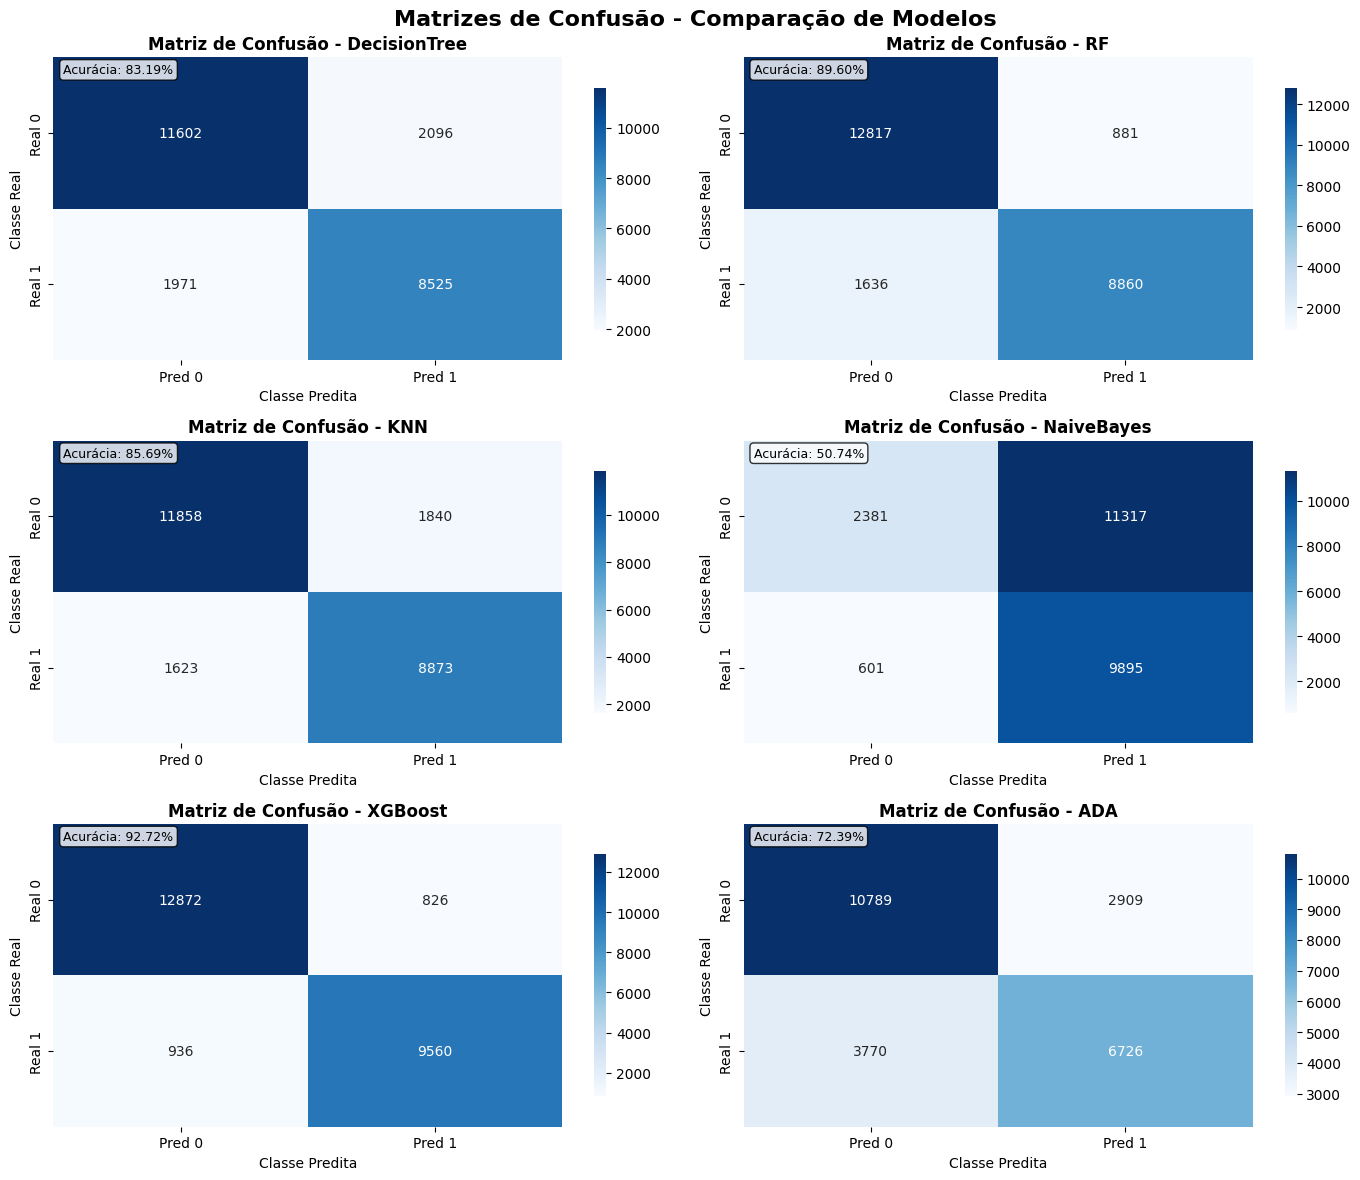


📈 RESUMO DOS RESULTADOS:
✅ Matrizes geradas com sucesso: 6
📊 Ranking por acurácia:
   🥇 XGBoost        :  92.72%
   🥈 RF             :  89.60%
   🥉 KNN            :  85.69%
    4. DecisionTree   :  83.19%
    5. ADA            :  72.39%
    6. NaiveBayes     :  50.74%

📊 Estatísticas de Acurácia:
   • Melhor: 92.72%
   • Pior: 50.74%
   • Média: 79.05%
   • Desvio: 14.17%

🎉 Layout: 3 linhas × 2 colunas
📊 Total processado: 6 modelos

✅ Função executada com sucesso!
📋 Resultados disponíveis na variável 'confusion_results'


In [ ]:
def generate_confusion_matrices(titles, X_test_scaled, y_test, figsize_per_model=(7, 4), cols=2, save_path=None, verbose=True):
    """
    Gera matrizes de confusão para múltiplos classificadores
    
    Parâmetros:
    - titles: lista de nomes dos classificadores desejados
    - X_test_scaled: dados de teste (features) já normalizados
    - y_test: rótulos de teste (target)
    - figsize_per_model: tupla com tamanho base de cada subplot (largura, altura)
    - cols: número de colunas no layout de subplots (padrão: 2)
    - save_path: caminho para salvar a figura (opcional)
    - verbose: se True, exibe progresso detalhado
    
    Retorna:
    - dict: dicionário com métricas de acurácia por classificador
    """
    
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Primeiro treinar os modelos
    if verbose:
        print("🔧 Treinando modelos para gerar matrizes de confusão...")
    
    trained_models = train_classifiers(
        titles=titles,
        X_train=datasets['X_train_scaled'],
        y_train=datasets['y_train'],
        verbose=False
    )
    
    # Filtrar apenas modelos treinados com sucesso
    methods = []
    valid_titles = []
    
    for title in titles if titles else trained_models.keys():
        if title in trained_models and trained_models[title]['status'] == 'success':
            methods.append(trained_models[title]['model'])
            valid_titles.append(title)
        elif verbose:
            print(f"   ⚠️ Pulando {title}: {trained_models.get(title, {}).get('error', 'Não encontrado')}")
    
    titles = valid_titles
    print("=====", titles)
    if verbose:
        print("🎯 GERANDO MATRIZES DE CONFUSÃO")
        print("=" * 50)
        print(f"📊 Configuração:")
        print(f"   • Número de modelos: {len(methods)}")
        print(f"   • Layout: {cols} colunas")
        print(f"   • Shape dados teste: {X_test_scaled.shape}")
        print(f"   • Classes únicas: {len(np.unique(y_test))}")
    
    # Calcular número de linhas necessárias
    n_models = len(methods)
    n_rows = (n_models + cols - 1) // cols  # Arredonda para cima
    
    # Criar subplots
    fig_width = figsize_per_model[0] * cols
    fig_height = figsize_per_model[1] * n_rows
    
    fig, axes = plt.subplots(n_rows, cols, figsize=(fig_width, fig_height))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Garantir que axes seja sempre um array 2D
    if n_rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Dicionário para armazenar resultados
    results = {}
    
    # Iterar pelos modelos e plotar matrizes de confusão
    for i, (clf, title) in enumerate(zip(methods, titles)):
        # Calcular posição na grade
        print(">>>>", clf, title)
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        if verbose:
            print(f"\n📊 [{i+1}/{n_models}] Processando: {title}")
        
        try:
            # Fazer predições
            y_predicted = clf.predict(X_test_scaled)
            
            # Calcular matriz de confusão
            cm = confusion_matrix(y_test, y_predicted)
            
            # Calcular acurácia
            accuracy = (cm.diagonal().sum() / cm.sum()) * 100
            
            # Criar DataFrame para melhor visualização
            unique_labels = np.unique(np.concatenate([y_test, y_predicted]))
            df_cm = pd.DataFrame(cm, 
                               index=[f'Real {label}' for label in unique_labels],
                               columns=[f'Pred {label}' for label in unique_labels])
            
            # Plotar usando seaborn heatmap
            sns.heatmap(df_cm, 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       ax=ax,
                       cbar_kws={'shrink': 0.8})
            
            # Configurar subplot
            ax.set_title(f'Matriz de Confusão - {title}', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Classe Predita', fontsize=10)
            ax.set_ylabel('Classe Real', fontsize=10)
            
            # Adicionar texto com acurácia
            ax.text(0.02, 0.98, f'Acurácia: {accuracy:.2f}%', 
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
            
            # Armazenar resultados
            results[title] = {
                'accuracy': accuracy / 100,  # Normalizar para [0,1]
                'confusion_matrix': cm,
                'predictions': y_predicted,
                'status': 'success'
            }
            
            if verbose:
                print(f"   ✅ {title}: Acurácia = {accuracy:.2f}%")
                
        except Exception as e:
            if verbose:
                print(f"   ❌ Erro ao processar {title}: {e}")
            
            # Plotar mensagem de erro
            ax.text(0.5, 0.5, f'Erro ao gerar\nmatriz para {title}', 
                   ha='center', va='center',
                   transform=ax.transAxes,
                   fontsize=12, color='red')
            ax.set_title(f'Erro - {title}', fontsize=12, color='red')
            
            # Armazenar erro
            results[title] = {
                'accuracy': None,
                'confusion_matrix': None,
                'predictions': None,
                'status': 'error',
                'error': str(e)
            }
    
    # Ocultar subplots extras
    for idx in range(n_models, n_rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    # Configurar título geral
    plt.suptitle('Matrizes de Confusão - Comparação de Modelos', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Salvar figura se solicitado
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            if verbose:
                print(f"\n💾 Figura salva em: {save_path}")
        except Exception as e:
            if verbose:
                print(f"\n❌ Erro ao salvar figura: {e}")
    
    plt.show()
    
    if verbose:
        print(f"\n📈 RESUMO DOS RESULTADOS:")
        print("=" * 50)
        
        # Filtrar sucessos
        successful_results = {k: v for k, v in results.items() if v['status'] == 'success'}
        
        if successful_results:
            # Ranking por acurácia
            sorted_results = sorted(successful_results.items(), 
                                  key=lambda x: x[1]['accuracy'], 
                                  reverse=True)
            
            print(f"✅ Matrizes geradas com sucesso: {len(successful_results)}")
            print(f"📊 Ranking por acurácia:")
            
            for rank, (name, data) in enumerate(sorted_results, 1):
                medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank:2d}."
                accuracy_pct = data['accuracy'] * 100
                print(f"   {medal} {name:15s}: {accuracy_pct:6.2f}%")
            
            # Estatísticas
            accuracies = [data['accuracy'] * 100 for data in successful_results.values()]
            print(f"\n📊 Estatísticas de Acurácia:")
            print(f"   • Melhor: {max(accuracies):.2f}%")
            print(f"   • Pior: {min(accuracies):.2f}%")
            print(f"   • Média: {np.mean(accuracies):.2f}%")
            print(f"   • Desvio: {np.std(accuracies):.2f}%")
        
        # Relatório de erros
        error_results = {k: v for k, v in results.items() if v['status'] == 'error'}
        if error_results:
            print(f"\n❌ Modelos com erro: {len(error_results)}")
            for name, data in error_results.items():
                print(f"   • {name}: {data['error']}")
        
        print(f"\n🎉 Layout: {n_rows} linhas × {cols} colunas")
        print(f"📊 Total processado: {n_models} modelos")
    
    return results

# Exemplo de uso da função
print("🚀 DEMONSTRAÇÃO DA FUNÇÃO generate_confusion_matrices()")
print("=" * 65)

def test_generate_confusion_matrices():
    # Usar a função com os classificadores treinados
    titles = None
    confusion_results = generate_confusion_matrices(
        titles=titles,
        X_test_scaled=datasets['X_test_scaled'],
        y_test=datasets['y_test'],
        figsize_per_model=(7, 4),
        cols=2,
        save_path=None,  # Para salvar: '../reports/confusion_matrices.png'
        verbose=True
    )

    print(f"\n✅ Função executada com sucesso!")
    print(f"📋 Resultados disponíveis na variável 'confusion_results'")

test_generate_confusion_matrices()

C:\Users\leopi\AppData\Local\Temp\ipykernel_29728\1903457535.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Dark2')


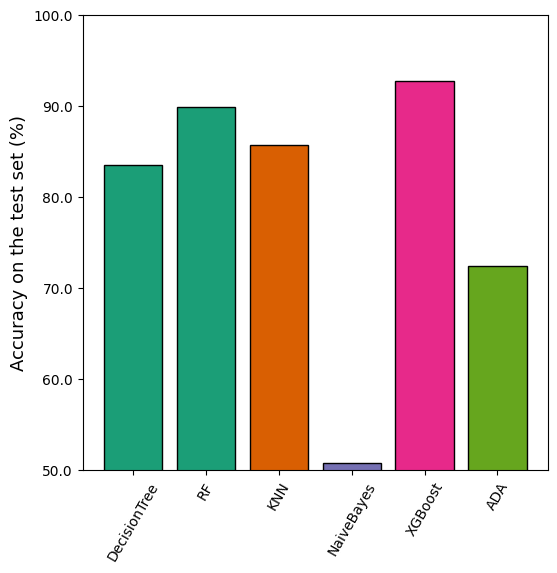

In [ ]:
###############################################################################
# Plotting the results
# -----------------------
# Let's now evaluate the methods on the test set.
#
cmap = get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, ax = plt.subplots(figsize=(6, 6.5))
pct_formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 100))
ax.bar(np.arange(len(methods)),
       scores,
       color=colors,
       tick_label=titles,
       edgecolor='k')

ax.set_ylim(0.50, 1.00)
ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
ax.yaxis.set_major_formatter(pct_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.subplots_adjust(bottom=0.18)
plt.show()